## Importando Bibliotecas

In [94]:
#Importando as bibliotecas utilizadas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_auc_score,roc_curve, classification_report,confusion_matrix,f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split,KFold
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score #acuracia
from sklearn.metrics import precision_score #precision
from sklearn.metrics import recall_score #recall
from sklearn.metrics import f1_score #f1-score
from sklearn.metrics import roc_auc_score #area sob curva roc
from sklearn.metrics import roc_curve #curva roc

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
import missingno as missing
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold 
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot #grafico

## Criando Driver no Colab


In [95]:
#Criando drive no colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Validando a pasta de onde está composto os arquivos de treino e test e aonde irei salvar o .ipynb
import os
os.chdir("/content/drive/My Drive/Competição FLAI")
!ls

1_5096068538829898114.pdf  sub_Emmanuel2.csv	     teste.csv
Emmanuel_3.ipynb	   sub_Emmanuel3.csv	     treino.csv
sub_Emmanuel1.csv	   submissao_Emmanuel.ipynb


##Testando Tunnning e gerando nova Submission


In [96]:
# importanto os conjuntos de dados disponíveis nesta mesma pasta Data
treino1 = pd.read_csv('/content/drive/My Drive/Competição FLAI/treino.csv')
sub1 = pd.read_csv('/content/drive/My Drive/Competição FLAI/teste.csv')

In [97]:
encoder=LabelEncoder()

transform = treino1.dtypes[treino1.dtypes == 'object'].keys()
for col in transform:
    if col !="Cliente":
      treino1[col] = encoder.fit_transform(list(treino1[col].values.astype('str')))
    


dic_cliente = {'Normal':0,'Premium':1}
treino1['Cliente1']=treino1['Cliente'].map(dic_cliente)
treino1.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Cliente,Cliente1
0,0,0,0,0,20,1,0,2,1,1,1,1,1,1,2,0,3,Normal,0
1,0,0,1,1,59,1,2,0,2,2,0,2,0,0,1,0,3,Premium,1
2,0,0,1,1,68,0,1,0,0,2,2,2,2,2,2,0,1,Premium,1
3,0,0,0,1,35,1,2,0,0,0,0,0,0,0,0,0,3,Premium,1
4,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,Normal,0
5,1,0,1,1,29,1,0,2,1,1,1,1,1,1,0,1,3,Normal,0
6,0,0,0,0,17,1,2,1,2,2,0,0,2,0,0,1,2,Premium,1
7,0,0,0,0,25,1,0,2,1,1,1,1,1,1,2,0,1,Normal,0
8,0,0,0,0,58,1,0,1,0,0,0,2,2,2,0,1,2,Premium,1
9,1,0,1,1,64,1,2,1,0,2,2,2,2,2,2,1,1,Premium,1


In [99]:
treino_new = treino1.drop(columns = ['Cliente'])
treino_new.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Cliente1
0,0,0,0,0,20,1,0,2,1,1,1,1,1,1,2,0,3,0
1,0,0,1,1,59,1,2,0,2,2,0,2,0,0,1,0,3,1


In [ ]:
#Criando variaveis independentes e dependentes
y = treino_new['Cliente1']
X = treino_new
X = treino_new.drop('Cliente1',axis = 1)
X

In [101]:
le = LabelEncoder()
X['Partner'] = le.fit_transform(X['Partner'])
X['Dependents'] = le.fit_transform(X['Dependents'])
X['gender'] = le.fit_transform(X['gender'])  
X['PhoneService'] = le.fit_transform(X['PhoneService'])  
X['PaperlessBilling'] = le.fit_transform(X['PaperlessBilling'])  
X['MultipleLines'] = le.fit_transform(X['MultipleLines'])
X.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,0,0,0,20,1,0,2,1,1,1,1,1,1,2,0,3
1,0,0,1,1,59,1,2,0,2,2,0,2,0,0,1,0,3


In [103]:
#Variáveis Continuas
x_cont=['tenure','gender']
x_cont

['tenure', 'gender']

In [ ]:
#Variáveis Categóricas
x_cat = list(set(X)-set(x_cont))
x_cat
x_dummies=X[x_cat]
x_dummies

In [ ]:
x_final = pd.get_dummies (data = X, columns=['Partner','Dependents'] )
x_final

In [ ]:
scaler = MinMaxScaler()
x_final[x_cont] = scaler.fit_transform(x_final[x_cont])
x_final[x_cont]

In [ ]:
x_treino, x_teste, y_treino,y_teste  = train_test_split(x_final, y, test_size = 0.25,random_state = 1)
x_treino

In [110]:
# Instancie o modelo com 1000 árvores de decisão 
rf = RandomForestClassifier (n_estimators = 1000, random_state = 1) 
# Treine o modelo nos dados de treinamento 
rf.fit (x_treino, y_treino);

In [111]:
y_rf = rf.predict(x_teste)
print (pd.crosstab(y_teste,y_rf, rownames=['Real'], colnames=['Predito'], margins=True))

Predito    0    1  All
Real                  
0        331   10  341
1         10  274  284
All      341  284  625


In [112]:
print(classification_report(y_teste, y_rf))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       341
           1       0.96      0.96      0.96       284

    accuracy                           0.97       625
   macro avg       0.97      0.97      0.97       625
weighted avg       0.97      0.97      0.97       625



In [113]:
#Analisando a importância de cada variável
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_, index = x_treino.columns, columns=['Importancia']).sort_values('Importancia',ascending=False)
feature_importances

,Importancia
tenure,0.432895
InternetService,0.069008
StreamingTV,0.066447
DeviceProtection,0.064420
MultipleLines,0.060471
OnlineBackup,0.053155
StreamingMovies,0.045260
Contract,0.041540
TechSupport,0.036610
OnlineSecurity,0.033307


In [114]:
# ajuste do modelo nos dados de treino
xgb = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1.0,
 seed=27)
xgb.fit(x_treino, y_treino)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [115]:
#fazendo as predições no dados de teste
preditos_xgb = xgb.predict(x_teste)
print (pd.crosstab(y_teste,preditos_xgb, rownames=['Real'], colnames=['Predito'], margins=True))

Predito    0    1  All
Real                  
0        338    3  341
1          7  277  284
All      345  280  625


In [116]:
print(classification_report(y_teste, preditos_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       341
           1       0.99      0.98      0.98       284

    accuracy                           0.98       625
   macro avg       0.98      0.98      0.98       625
weighted avg       0.98      0.98      0.98       625



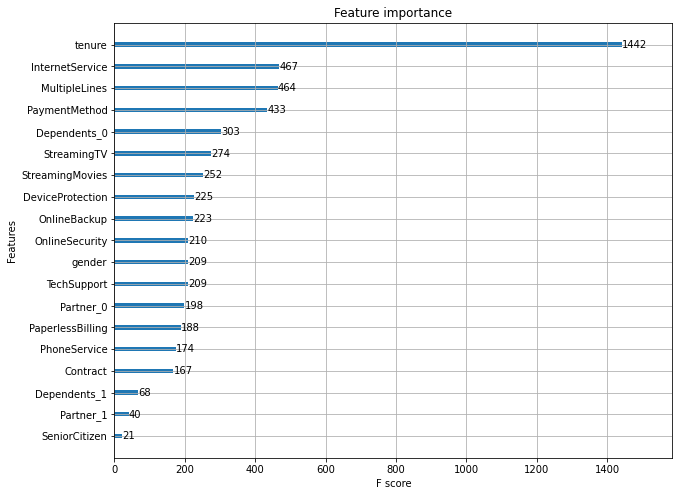

In [117]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb, ax=ax)

In [118]:
# Voting Classifier with soft voting 
voto = VotingClassifier(estimators=[('rf', rf),('xgb',xgb)], voting='soft')
voto = voto.fit(x_treino,y_treino)

In [119]:
y_predito = voto.predict(x_teste)
print (pd.crosstab(y_teste,y_predito, rownames=['Real'], colnames=['Predito'], margins=True))

Predito    0    1  All
Real                  
0        338    3  341
1          7  277  284
All      345  280  625


In [120]:
print(classification_report(y_teste, y_predito))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       341
           1       0.99      0.98      0.98       284

    accuracy                           0.98       625
   macro avg       0.98      0.98      0.98       625
weighted avg       0.98      0.98      0.98       625



In [121]:
treino1['probabilidade'] = voto.predict_proba(x_final[x_treino.columns])[:,1]
treino1[['Cliente1','probabilidade']]

,Cliente1,probabilidade
0,0,0.000501
1,1,0.961991
2,1,0.999472
3,1,0.647912
4,0,0.000500
...,...,...
2495,0,0.011115
2496,1,0.943441
2497,1,0.997500
2498,0,0.017501


In [122]:
transform_2 = sub1.dtypes[sub1.dtypes == 'object'].keys()
for col in transform_2:
  sub1[col] = encoder.fit_transform(list(sub1[col].values.astype('str')))
    
sub1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,0,1,1,23,1,0,2,1,1,1,1,1,1,1,0,3
1,0,0,0,0,27,1,0,0,2,2,0,0,0,0,0,1,3
2,1,0,0,0,2,1,0,2,1,1,1,1,1,1,0,0,3
3,0,0,0,0,48,1,0,1,2,0,2,2,2,2,2,1,1
4,1,0,1,0,71,1,0,1,0,2,2,2,2,2,2,1,2


In [123]:
#submission3
treino1['probabilidade'] = voto.predict_proba(x_final[x_treino.columns])[:,1]
subm3 = treino1[['Cliente1']]
subm3

,Cliente1
0,0
1,1
2,1
3,1
4,0
...,...
2495,0
2496,1
2497,1
2498,0


In [124]:
subm3.to_csv('/content/drive/My Drive/Competição FLAI/sub_Emmanuel2.csv', index = False)

In [ ]:
subm3

,Cliente1
0,0
1,1
2,1
3,1
4,0
...,...
2495,0
2496,1
2497,1
2498,0
